# Intel® Neural Compressor Sample for TensorFlow*

## Agenda
- Train a convolutional neural network (CNN) model by using Keras
- Quantize the Keras model by using Intel® Neural Compressor
- Compare the performance of quantized model with the original model

## Setup

Import python packages and verify that the correct versions are installed.

Required packages:
- TensorFlow 2.2 and later
- Intel® Neural Compressor 1.2.1 and later
- Matplotlib

**Note**: This code sample supports both the current package name for Intel® Neural Compressor (**neural_compressor**) and the old names (**lpot**, **ilit**).

In [1]:
import os
import tensorflow as tf
print("Tensorflow version {}".format(tf.__version__))
tf.compat.v1.enable_eager_execution()

try:
    import neural_compressor as inc
    print("neural_compressor version {}".format(inc.__version__))  
except:
    try:
        import lpot as inc
        print("LPOT version {}".format(inc.__version__)) 
    except:
        import ilit as inc
        print("iLiT version {}".format(inc.__version__))       

import matplotlib.pyplot as plt
import numpy as np

from IPython import display

2022-12-15 22:59:23.176110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 22:59:23.306566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glob/development-tools/versions/oneapi/2022.3.1/oneapi/intelpython/latest/lib/libfabric:
2022-12-15 22:59:23.306602: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-15 22:59:30.038215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic 

Tensorflow version 2.11.0
neural_compressor version 1.14.2


### Environment Setting

For Intel Optimized TensorFlow 2.5.0 and later, you must set the **TF_ENABLE_ONEDNN_OPTS=1** environment variable before running Intel® Neural Compressor to quantize FP32 model or deploying the quantized model.

In [3]:
%env TF_ENABLE_ONEDNN_OPTS=1

env: TF_ENABLE_ONEDNN_OPTS=1


## Train a CNN Model Based on Keras

We prepared the `alexnet.py` script with the functions for training a CNN model.

### Dataset
Use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits. 
Load the dataset.

In [4]:
import alexnet
 
data = alexnet.read_data()
x_train, y_train, label_train, x_test, y_test, label_test = data
print('train', x_train.shape, y_train.shape, label_train.shape)
print('test', x_test.shape, y_test.shape, label_test.shape)


Loading data ...
Done
train (60000, 28, 28, 1) (60000, 10) (60000,)
test (10000, 28, 28, 1) (10000, 10) (10000,)


### Build Model

Build a CNN model like Alexnet by using Keras API based on TensorFlow.
Use the Keras `summary()` method to print the model structure.

In [5]:
classes = 10
width = 28
channels = 1

model = alexnet.create_model(width ,channels ,classes)

model.summary()

2022-12-15 23:01:21.057970: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/u177489/env_inc/lib/python3.9/site-packages/cv2/../../lib64:/glob/development-tools/versions/oneapi/2022.3.1/oneapi/intelpython/latest/lib/libfabric:
2022-12-15 23:01:21.058033: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 23:01:21.058079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s001-n014): /proc/driver/nvidia/version does not exist
2022-12-15 23:01:21.059014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  A

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 96)        11712     
                                                                 
 activation (Activation)     (None, 28, 28, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 14, 14, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                    

### Train the Model with the Dataset

Set the **epochs** parameter to **3**.

In [6]:
epochs = 1

alexnet.train_mod(model, data, epochs)

100/100 [==============================] - 575s 6s/step - loss: 0.4589 - accuracy: 0.8442 - val_loss: 0.0668 - val_accuracy: 0.9776
Test score: 0.06683540344238281
Test accuracy: 0.9775999784469604


### Freeze and Save Model to Single PB

Set the input node name to **x**.

In [7]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def save_frozen_pb(model, mod_path):
    # Convert Keras model to ConcreteFunction
    full_model = tf.function(lambda x: model(x))
    concrete_function = full_model.get_concrete_function(
        x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    # Get frozen ConcreteFunction
    frozen_model = convert_variables_to_constants_v2(concrete_function)

    # Generate frozen pb
    tf.io.write_graph(graph_or_graph_def=frozen_model.graph,
                      logdir=".",
                      name=mod_path,
                      as_text=False)
fp32_frozen_pb_file = "fp32_frozen.pb"
save_frozen_pb(model, fp32_frozen_pb_file)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2022-12-15 23:11:14 [WARNING] From /home/u177489/env_inc/lib/python3.9/site-packages/tensorflow/python/autograph/pyct/static_analysis/liveness.py:83: Analyzer.lamba_check (from tensorflow.python.autograph.pyct.static_analysis.liveness) is deprecated and will be removed after 2023-09-23.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2022-12-15 23:11:14.493277: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-12-15 23:11:14.493409: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


In [8]:
%ls -la fp32_frozen.pb

-rw------- 1 u177489 u177489 27760621 Dec 15 23:11 fp32_frozen.pb


## Quantize FP32 Model by Using Intel® Neural Compressor

Intel® Neural Compressor can quantize the model with a validation dataset for tuning.
As a result, it returns a frozen quantized INT8 model.

We prepare a python script `inc_quantize_model.py` to call Intel® Neural Compressor to finish the all quantization job.
See the following code sample for explanations.



### Define Load FP32 Model
Load the FP32 model that we saved in the previous step. See the `alexnet.load_pb(in_model)` function.

In [9]:
display.Code('alexnet.py')

import os
import numpy as np

import tensorflow as tf
from tensorflow.python.keras import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow import keras

import mnist_dataset


def save_mod(model, mod_path):
    print('Save to {}'.format(mod_path))
    tf.saved_model.save(model, mod_path)


def load_mod(model_file):
    model = tf.keras.models.load_model(model_file)
    print('Load from {}'.format(model_file))
    return model

def save_frezon_pb(model, mod_path):
    # Convert Keras model to ConcreteFunction
    full_model = tf.function(lambda x: model(x))
    concrete_function = full_model.get_concrete_function(
        x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    # Get frozen ConcreteFunction
    frozen_model = convert_variables_to_constants_v2(concrete_function)

    # Generate frozen pb
    tf.io.write_graph(graph_or_graph_def=frozen_model.graph,
                      logdir=".",
                      name=mod_path,
                      as_text=False)


def load_pb(in_model):
    detection_graph = tf.compat.v1.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.compat.v1.gfile.GFile(in_model, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.compat.v1.import_graph_def(od_graph_def, name='')

    return detection_graph

def read_data():
    x_train, y_train, label_train, x_test, y_test, label_test = mnist_dataset.read_data()
    return x_train, y_train, label_train, x_test, y_test, label_test

def create_model(w, c, classes):
    model = Sequential()
    model.add(Convolution2D(96, 11, input_shape=(w, w, c), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(256, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(384, 3, padding='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(384, 3, padding='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(256, 3, padding='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(256, 7))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(classes))
    model.add(Activation('softmax'))

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_mod(model, data, epochs=3):
    x_train, y_train, label_train, x_test, y_test, label_test = data
    model.fit(x_train, y_train, epochs=epochs, batch_size=600, validation_data=(x_test, y_test), verbose=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

def main():
    data = read_data()

    classes = 10
    w = 28
    c = 1
    model = create_model(w ,c, classes)
    model.summary()

    epochs = 3
    train_mod(model, data, epochs)
    save_mod(model, "alexnet_mnist_fp32_mod")

if __name__ == "__main__":
    main()

### Define Yaml File

We created `alexnet.yaml` to save the necessary parameters for Intel® Neural Compressor.
In this case, we only need to change the input/output according to the FP32 model.

The input node name is **x**.

The output name is **Identity**.

In [10]:
display.Code('alexnet.yaml')

version: 1.0

model:
  name: hello_world
  framework: tensorflow                          # possible values are tensorflow, mxnet and pytorch
  inputs: x
  outputs: Identity

evaluation:
  accuracy:
    metric:
      topk: 1

tuning:
  accuracy_criterion:
    relative: 0.01                              # the tuning target of accuracy loss percentage: 1%
  exit_policy:
    timeout: 0                                   # tuning timeout (seconds)
  random_seed: 100                               # random seed

### Call Function to Quantize the Model

Show the code in `inc_quantize_model.py`.

In [11]:
display.Code('inc_quantize_model.py')

"""
Environment Setting

Enable Intel Optimized TensorFlow 2.6.0 and newer by setting environment variable TF_ENABLE_ONEDNN_OPTS=1
That will accelerate training and inference, and  it's mandatory requirement of running Intel® Neural Compressor quantize Fp32 model or deploying the quantized model.
"""

import neural_compressor as inc
print("neural_compressor version {}".format(inc.__version__))

import tensorflow as tf
print("tensorflow {}".format(tf.__version__))

from neural_compressor.experimental import Quantization, common
import mnist_dataset


class Dataset(object):
    def __init__(self):
        _x_train, _y_train, label_train, x_test, y_test, label_test = mnist_dataset.read_data()

        self.test_images = x_test
        self.labels = label_test

    def __getitem__(self, index):
        return self.test_images[index], self.labels[index]

    def __len__(self):
        return len(self.test_images)

def ver2int(ver):
    s_vers = ver.split(".")
    res = 0
    for i, s in enumerate(s_vers):
        res += int(s)*(100**(2-i))

    return res

def compare_ver(src, dst):
    src_ver = ver2int(src)
    dst_ver = ver2int(dst)
    if src_ver>dst_ver:
        return 1
    if src_ver<dst_ver:
        return -1
    return 0

def auto_tune(input_graph_path, yaml_config, batch_size, int8_pb_file):
    quantizer = Quantization(yaml_config)
    dataset = Dataset()
    quantizer.calib_dataloader = common.DataLoader(dataset, batch_size=batch_size)
    quantizer.eval_dataloader = common.DataLoader(dataset, batch_size=batch_size)
    quantizer.model = common.Model(input_graph_path)
    if compare_ver(inc.__version__, "1.9")>=0:
        q_model = quantizer.fit()
    else:
        q_model = quantizer()

    return q_model


yaml_file = "alexnet.yaml"
batch_size = 200
fp32_frozen_pb_file = "fp32_frozen.pb"
int8_pb_file = "alexnet_int8_model.pb"

q_model = auto_tune(fp32_frozen_pb_file, yaml_file, batch_size, int8_pb_file)
q_model.save(int8_pb_file)

We will execute `inc_quantize_model.py` to show the whole process of quantizing a model.

In [13]:
!~/env_inc/bin/python inc_quantize_model.py

neural_compressor version 1.14.2
2022-12-15 23:12:23.771195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 23:12:23.898061: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-15 23:12:23.902080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/u177489/env_inc/lib/python3.9/site-packages/cv2/../../li

The script creates the file `alexnet_int8_model.pb` that contains the quantized model.

## Compare Performance of FP32 without oneDNN, with oneDNN, and int8 Quantized Model

We prepare the script `profiling_inc.py` to test the performance of the PB model.

If we run the code in the jupyter notebook, we will not get the correct performance data. So we run the script as a process.

Let's take a look at `profiling_inc.py`.

In [12]:
display.Code('profiling_inc.py')

import tensorflow as tf
print("Tensorflow version {}".format(tf.__version__))

import numpy as np
import time
import argparse
import os
import json


import mnist_dataset
import alexnet


def val_data():
    x_train, y_train, label_train, x_test, y_test, label_test = mnist_dataset.read_data()
    return x_test, y_test, label_test


def calc_accuracy(predictions, labels):
    predictions = np.argmax(predictions, axis=1)
    same = 0
    for i, x in enumerate(predictions):
        if x == labels[i]:
            same += 1
    if len(predictions) == 0:
        return 0
    else:
        return same / len(predictions)


def get_concrete_function(graph_def, inputs, outputs, print_graph=False):
    def imports_graph_def():
        tf.compat.v1.import_graph_def(graph_def, name="")

    wrap_function = tf.compat.v1.wrap_function(imports_graph_def, [])
    graph = wrap_function.graph

    return wrap_function.prune(
        tf.nest.map_structure(graph.as_graph_element, inputs),
        tf.nest.map_structure(graph.as_graph_element, outputs))


def infer_perf_pb(pb_model_file, val_data, inputs=["x:0"], outputs=["Identity:0"]):
    x_test, y_test, label_test = val_data
    q_model = alexnet.load_pb(pb_model_file)
    concrete_function = get_concrete_function(graph_def=q_model.as_graph_def(),
                                              inputs=inputs,
                                              outputs=outputs,
                                              print_graph=True)

    bt = time.time()
    _frozen_graph_predictions = concrete_function(x=tf.constant(x_test))
    et = time.time()

    accuracy = calc_accuracy(_frozen_graph_predictions[0], label_test)
    print('accuracy:', accuracy)
    throughput = x_test.shape[0] / (et - bt)
    print('max throughput(fps):', throughput)

    # latency when BS=1
    times = 1000
    single_test = x_test[:1]

    bt = 0
    warmup = 20
    for i in range(times):
        if i == warmup:
            bt = time.time()
        _frozen_graph_predictions = concrete_function(x=tf.constant(single_test))
    et = time.time()

    latency = (et - bt) * 1000 / (times - warmup)
    print('latency(ms):', latency)

    return accuracy, throughput, latency


def save_res(result):
    accuracy, throughput, latency = result
    res = {}
    res['accuracy'] = accuracy
    res['throughput'] = throughput
    res['latency'] = latency

    outfile = args.index + ".json"
    with open(outfile, 'w') as f:
        json.dump(res, f)
        print("Save result to {}".format(outfile))

parser = argparse.ArgumentParser()
parser.add_argument('--index', type=str, help='file name of output', required=True)

parser.add_argument('--input-graph', type=str, help='file name for graph', required=True)

parser.add_argument('--num-intra-threads', type=str, help='number of threads for an operator', required=False,
                    default="24" )
parser.add_argument('--num-inter-threads', type=str, help='number of threads across operators', required=False,
                    default="1")
parser.add_argument('--omp-num-threads', type=str, help='number of threads to use', required=False,
                    default="24")

args = parser.parse_args()
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "0"
os.environ["OMP_NUM_THREADS"] = args.omp_num_threads
os.environ["TF_NUM_INTEROP_THREADS"] = args.num_inter_threads
os.environ["TF_NUM_INTRAOP_THREADS"] = args.num_intra_threads

save_res(infer_perf_pb(args.input_graph, val_data()))

### Comparison using job submission

In [27]:
%%writefile compare.sh
#!/bin/bash

#Remove old files 
rm -rf compare.sh.*

export TF_ENABLE_ONEDNN_OPTS=0

echo "Execute the profiling_inc.py without oneDNN using FP32 model file"
~/env_inc/bin/python profiling_inc.py --input-graph=./fp32_frozen.pb --num-inter-threads=1 --num-intra-threads=6 --index=032
echo "FP32 w/o oneDNN performance test is finished"

export TF_ENABLE_ONEDNN_OPTS=1

echo "Execute the profiling_inc.py with oneDNN using FP32 model file"
~/env_inc/bin/python profiling_inc.py --input-graph=./fp32_frozen.pb --omp-num-threads=6 --num-inter-threads=1 --num-intra-threads=6 --index=132
echo "FP32 with oneDNN performance test is finished"

echo "Execute the profiling_inc.py with INT8 model file"
~/env_inc/bin/python profiling_inc.py --input-graph=./alexnet_int8_model.pb --omp-num-threads=6 --num-inter-threads=1 --num-intra-threads=6 --index=8
echo "INT8 performance test is finished"



Writing compare.sh


In [28]:
!qsub compare.sh -d `pwd` -l nodes=1:icx:ppn=2

2092910.v-qsvr-1.aidevcloud


In [33]:
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2092763.v-qsvr-1           ...ub-singleuser u177489         01:13:22 R jupyterhub     


In [55]:
!tail -40 `ls -lAtr compare.sh.o* |  tail -1 | awk '{print $9}'`

########################################################################
#      Date:           Thu 15 Dec 2022 11:29:39 PM PST
#    Job ID:           2092910.v-qsvr-1.aidevcloud
#      User:           u177489
# Resources:           cput=75:00:00,neednodes=1:icx:ppn=2,nodes=1:icx:ppn=2,walltime=06:00:00
########################################################################

Execute the profiling_inc.py with FP32 model file
Tensorflow version 2.11.0
Loading data ...
Done
accuracy: 0.9776
max throughput(fps): 564.3249506520549
latency(ms): 11.232740781745132
Save result to 032.json
FP32 w/o oneDNN performance test is finished
Execute the profiling_inc.py with FP32 model file
Tensorflow version 2.11.0
Loading data ...
Done
accuracy: 0.9776
max throughput(fps): 786.2986093552892
latency(ms): 8.947673865727015
Save result to 132.json
FP32 with oneDNN performance test is finished
Execute the profiling_inc.py with INT8 model file
Tensorflow version 2.11.0
Loading data ...
Done
accuracy: 0.9

### Using notebook

### Disable oneDNN and Record the performance numbers

In [40]:
%env TF_ENABLE_ONEDNN_OPTS=0

env: TF_ENABLE_ONEDNN_OPTS=0


In [15]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          24
On-line CPU(s) list:             0-23
Thread(s) per core:              2
Core(s) per socket:              6
Socket(s):                       2
NUMA node(s):                    2
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
Stepping:                        4
CPU MHz:                         1200.126
CPU max MHz:                     3700.0000
CPU min MHz:                     1200.0000
BogoMIPS:                        6800.00
Virtualization:                  VT-x
L1d cache:                       384 KiB
L1i cache:                       384 KiB
L2 cache:                        12 MiB
L3 cache:                    

Execute `profiling_inc.py` with the FP32 model file:

In [41]:
!~/env_inc/bin/python profiling_inc.py --input-graph=./fp32_frozen.pb --num-inter-threads=1 --num-intra-threads=6 --index=032

2022-12-16 00:43:05.772476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 00:43:05.886724: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/u177489/env_inc/lib/python3.9/site-packages/cv2/../../lib64:/glob/development-tools/versions/oneapi/2022.3.1/oneapi/intelpython/latest/lib/libfabric:
2022-12-16 00:43:05.886765: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-16 00:43:06.616020: W tensorflow/compiler/xla/stream_e

### Enable oneDNN and Record the performance numbers

In [42]:
%env TF_ENABLE_ONEDNN_OPTS=1

env: TF_ENABLE_ONEDNN_OPTS=1


Execute `profiling_inc.py` with the FP32 model file:

In [51]:
!~/env_inc/bin/python profiling_inc.py --input-graph=./fp32_frozen.pb --omp-num-threads=6 --num-inter-threads=1 --num-intra-threads=6 --index=132

/bin/bash: /home/u177489//bin/python: No such file or directory


### Now record the performance numbers for int8 quantized model

Execute `profiling_inc.py` with the INT8 model file:

In [45]:
!~/env_inc/bin/python profiling_inc.py --input-graph=./alexnet_int8_model.pb --omp-num-threads=6 --num-inter-threads=1 --num-intra-threads=6 --index=8

2022-12-16 00:45:08.715102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 00:45:08.834569: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-16 00:45:08.837916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/u177489/env_inc/lib/python3.9/site-packages/cv2/../../lib64:/glob/development-tools/versi

In [ ]:
display.Code('32.json')
!echo " "
display.Code('8.json')

Execute the functions to load and show the performance data from the `32.json` and `8.json` files.

throughputs [564.3249506520549, 786.2986093552892, 1639.871400236853]
latencys [11.232740781745132, 8.947673865727015, 6.084075266001176]
accuracys [0.9776, 0.9776, 0.9779]


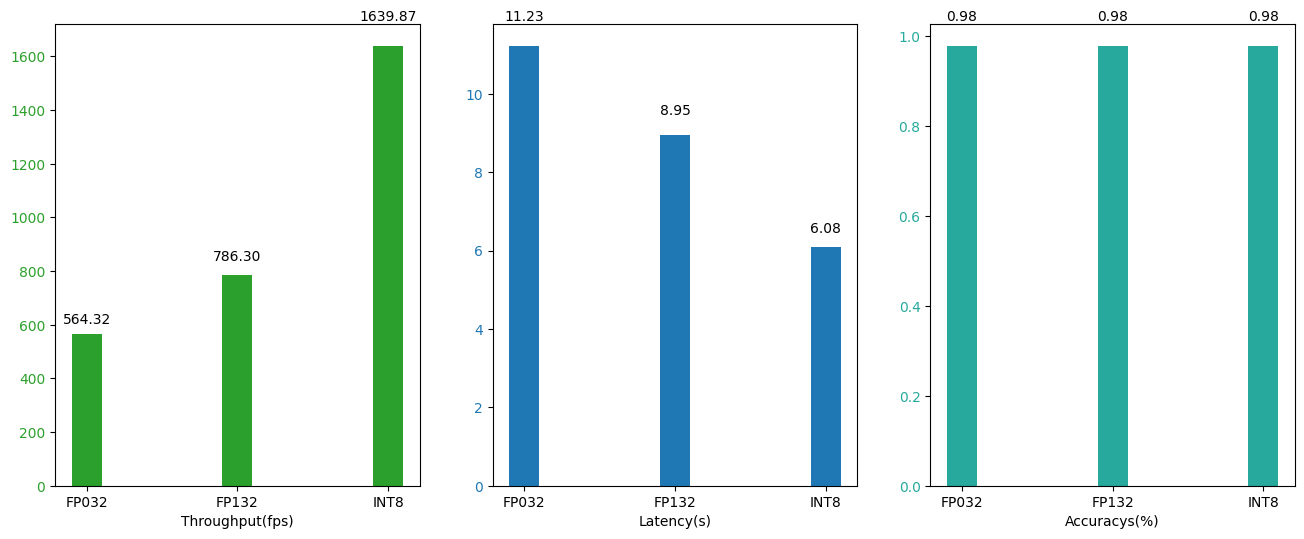

In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np

def autolabel(ax, rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%0.2f' % float(height),
        ha='center', va='bottom')

def draw_bar(x, t, y, subplot, color, x_lab, y_lab, width=0.2):
    plt.subplot(subplot)
    plt.xticks(x, t)
    ax1 = plt.gca()
    ax1.set_xlabel(x_lab)
    ax1.set_ylabel(y_lab, color=color)
    rects1 = ax1.bar(x, y, color=color, width=width)
    ax1.tick_params(axis='y', labelcolor=color)
    autolabel(ax1, rects1)

def load_res(json_file):
    with open(json_file) as f:
        data = json.load(f)
        return data

res_032 = load_res('032.json')
res_132 = load_res('132.json')
res_8 = load_res('8.json')
   
accuracys = [res_032['accuracy'], res_132['accuracy'], res_8['accuracy']]
throughputs = [res_032['throughput'], res_132['throughput'], res_8['throughput']]             
latencys = [res_032['latency'],res_132['latency'], res_8['latency']]

print('throughputs', throughputs)
print('latencys', latencys)
print('accuracys', accuracys)

accuracys_perc = [accu*100 for accu in accuracys]

t = ['FP032', 'FP132', 'INT8']
x = [0, 1, 2]
plt.figure(figsize=(16,6))
draw_bar(x, t, throughputs, 131, 'tab:green', 'Throughput(fps)', '', width=0.2)
draw_bar(x, t,  latencys, 132, 'tab:blue', 'Latency(s)', '', width=0.2)
draw_bar(x, t,  accuracys, 133, '#28a99d', 'Accuracys(%)', '', width=0.2)
plt.show()

### FP32 vs INT8

Compare the performance data of the INT8 model with that of the FP32 model.

throughputs_times [1, 1.3933436904513128, 2.9058991603012543]
latencys_times [1, 0.7965708494108856, 0.5416376451852872]
accuracys_times [0, 0.0, 0.029999999999986926]


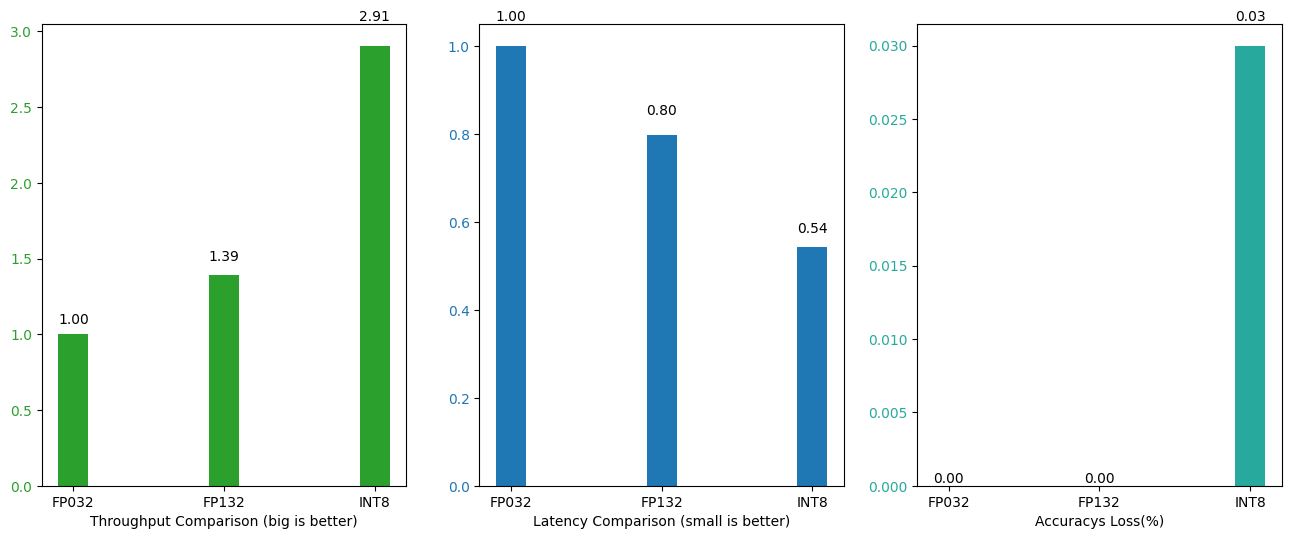

In [36]:
throughputs_times = [1, throughputs[1]/throughputs[0] , throughputs[2]/throughputs[0]]
latencys_times = [1, latencys[1]/latencys[0], latencys[2]/latencys[0] ]
accuracys_times = [0, accuracys_perc[1] - accuracys_perc[0], accuracys_perc[2] - accuracys_perc[0]]

print('throughputs_times', throughputs_times)
print('latencys_times', latencys_times)
print('accuracys_times', accuracys_times)

plt.figure(figsize=(16,6))
draw_bar(x, t, throughputs_times, 131, 'tab:green', 'Throughput Comparison (big is better)', '', width=0.2)
draw_bar(x, t, latencys_times, 132, 'tab:blue', 'Latency Comparison (small is better)', '', width=0.2)
draw_bar(x, t, accuracys_times, 133, '#28a99d', 'Accuracys Loss(%)', '', width=0.2)
plt.show()

## Conclusion

In [23]:
print("[CODE_SAMPLE_COMPLETED_SUCCESFULLY]")

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]


In this code sample we have compared performance of the FP32 and INT8 models and demonstrated that the INT8 model is faster.

The Second Generation Intel® Xeon® Scalable processors provide Intel® Deep Learning Boost that speeds up the INT8 inference.